In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from google.colab import drive
drive.mount('/content/drive')

# Plot constants and colors
BAR_COLOR  = '#e66707'
BAR_COLOR2 = '#a32c1a'
BAR_COLOR3 = '#309e15'
TICK_COLOR = '#000000'
TITLE_FONT_SIZE= 16
LABEL_FONT_SIZE= 14
################################

In [2]:
# Training and testing data loading

train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic_data/titanic_train.csv')
test_df  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic_data/titanic_test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**PassengerId, Ticket and cabin** feature can be dropped immediately as they seem irrelevant to chance of survival.

**Pclass and Fare** feature shows how wealthy is someone and have correlation to survival chance as richer have higher odds.

Woman and children have higher chance of survival so **Sex and Age** features are correlated to survival.

**SibSp, Parch and Embarked** features are yet to be determined are they correlated to survival.

**Name** feature on the first hand may seem irrelevant, however there are some tokens such as Mr or Miss, etc. that repeats a lot of time and may be correlated to survival so we will leave them for now.

In [3]:
# Dropping irrelevant features

train_df = train_df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
test_df  = test_df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
train_and_test = [train_df,test_df]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


**Age and Embarked** features contain missing values, so we are going to fill them in. Embarked feature missing only 2 values and may seem less important correlation to survival so we are going to fill NaN with most frequent value.

Since Age feature missing a lot of values it could be filled with either median value or random value between median and std or with median value for Sex and Pclass features only since they seem most correlated with Age while others have little to no correlation with Age.

And in test data Fare is missing only 1 value and will be filled with median value, and Age will be filled like train df.

In [4]:
# filling Embarked NaN

train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].describe()[2])
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

# filling Age NaN
# We are going to iterate over dataset and for each NaN in Age column replace it with Age median value for each
# Sex and Pclass subset.

age_median_values = train_df[['Sex','Pclass','Age']].groupby(['Sex','Pclass'], as_index=False).median()

for dataset in train_and_test:
  for i in ['male','female']:
      for j in [1,2,3]:
          dataset.loc[(dataset['Age'].isnull()) & (dataset.Sex == i) & (dataset.Pclass == j), 'Age'] = \
          int(age_median_values[(age_median_values.Sex == i) & (age_median_values.Pclass == j)]['Age'])

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.088855,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.318340,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Male/Female ratio is that were on ship was: 1.84

Number of people embarked in:
  Southampton: 646
  Cherbourg:   168
  Queenstown:   77



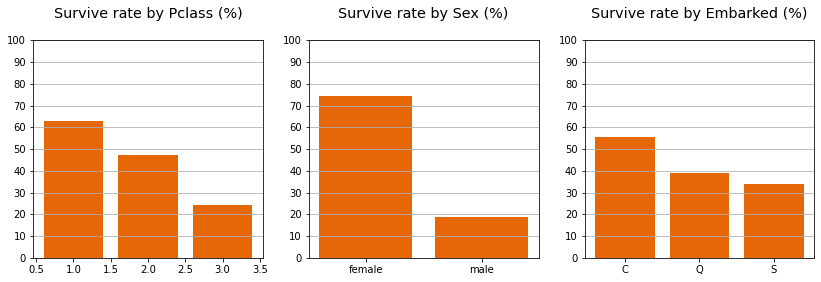

In [6]:
tmp = train_df['Sex'].value_counts()['male']/train_df['Sex'].value_counts()['female']
print("Male/Female ratio is that were on ship was: " + str(round(tmp,2))+ "\n")

tmp = train_df['Embarked'].value_counts()
print("Number of people embarked in:\n  Southampton: " + str(round(tmp[0],2))+ "\n"+\
      "  Cherbourg:   " + str(round(tmp[1],2))+ "\n" + \
      "  Queenstown:   " + str(round(tmp[2],2))+ "\n")

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace = 0.4)
k=131
for ftr in ['Pclass', 'Sex', 'Embarked']:
    tmp = train_df[[ftr, 'Survived']].groupby([ftr], as_index=False).mean()
    plt.subplot(k)
    k+=1
    plt.bar(tmp[ftr],tmp['Survived']*100, color=BAR_COLOR)
    plt.title("Survive rate by " + ftr + " (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
    plt.yticks(ticks=range(0,101,10))
    plt.grid(axis='y')

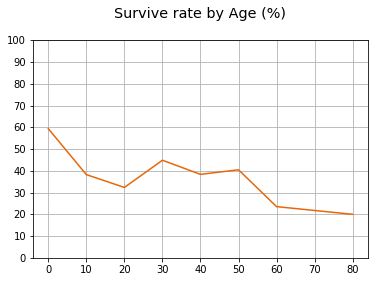

In [7]:
# Age feture analysis

# using pd.cut in 8 bands we can see that there are 8 bands with 9.948 yesrs range
# train_df['AgeBand'] = pd.cut(train_df['Age'], 8)

k=1
for dataset in train_and_test:
    dataset.loc[ dataset['Age'] <= 10.368, 'Age'] = 0
    for i in np.arange(10.368, 70.051, 9.948):
        dataset.loc[(dataset['Age'] > i) & (dataset['Age'] <= i+9.948), 'Age'] = k
        k+=1
    dataset.loc[ dataset['Age'] > 70.052, 'Age'] = 8
    dataset['Age'] = dataset['Age'].astype(int)

tmp = train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Age', ascending=True)
plt.plot(tmp['Age']*10,tmp['Survived']*100, color=BAR_COLOR)
plt.title("Survive rate by Age (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
plt.yticks(ticks=range(0,101,10))
plt.grid(axis='both')

As expected children had higher survival chance. Age feature have high correlation to survival and will be used in predicting algoritms in this form as 8 bands with around 10 years range.

We are going to make bands out of Fare like Age. Since most of people bought ticket for less than 50 dollars, and couple of people bought for 512 dollars so we cant split in in equal bands like Age. We have to use pd.qcut which will cut them so that each band have same number of people in it.

While doing banding like this on train set, we must pay atention that all values in test set are in between min and max of train set

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,2,1,0,0,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,7,C
2,1,3,"Heikkinen, Miss. Laina",female,2,0,0,2,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,6,S
4,0,3,"Allen, Mr. William Henry",male,3,0,0,2,S


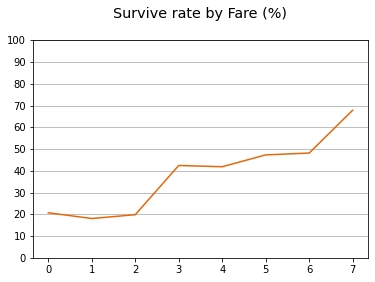

In [8]:
# Fare feature analysis
train_df['FareBand_tmp'] = pd.qcut(train_df['Fare'], 8)

k=1
for dataset in train_and_test:
    dataset['FareBand'] = round(dataset['Fare'],2)
    for i in range(8):
        l = train_df['FareBand_tmp'].unique().sort_values()[i].left
        r = train_df['FareBand_tmp'].unique().sort_values()[i].right + 0.01
        dataset.loc[ (dataset['Fare'] > l) & (dataset['Fare'] <=r), 'FareBand'] = i
    dataset['Fare'] = dataset['FareBand'].astype(int)

train_df = train_df.drop(['FareBand', 'FareBand_tmp'], axis=1)
test_df  =  test_df.drop(['FareBand'], axis=1)
train_and_test = [train_df,test_df]

tmp = train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean()
plt.plot(tmp['Fare'],tmp['Survived']*100, color=BAR_COLOR)
plt.title("Survive rate by " + 'Fare' + " (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
plt.yticks(ticks=range(0,101,10))
plt.grid(axis='y')

train_df.head()

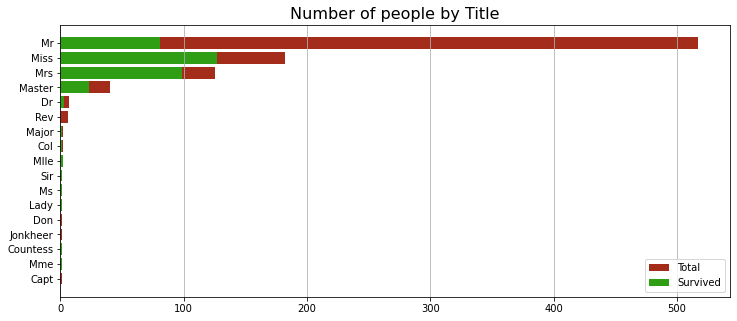

In [9]:
# Name feature analisys

train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

x = []
y = []
for i in train_df.Title.unique():
    tmp = train_df[train_df.Title==i]
    x.append(i)
    y.append(tmp[tmp.Survived==1].count()[0])

train_df.Title.value_counts()
plt.figure(figsize=(12, 5))
tmp = train_df.Title.value_counts().sort_values(ascending=True)
plt.barh(tmp.index,tmp,color=BAR_COLOR2)
plt.barh(x,y,color=BAR_COLOR3)
plt.title("Number of people by Title", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.legend(['Total','Survived'], loc="lower right")
plt.grid(axis='x')

As we can see making Title feature from Name feature can help analysing how Name impact chances of survival. If we look closer to graph above we could see  that 4 Titles have high enough number of samples to be considered. Percentage of people who survived with Mr, Miss or Mrs Title is close to survival rate by sex. Also people with master title would tend to be richer. Because same informations are contained within Sex, Pclass and Fare feature, Title feature can be dropped as well as Name feature.

Since we are going to use some algorithms that work only with continious values we need to change categorical features(Sex and Embarked) to numerical.


Embarked remapped to:

S: 0

C: 1

Q: 2

Sex remapped to:

female: 0

male:   1

In [10]:
train_df = train_df.drop(['Name','Title'], axis=1)
test_df  = test_df.drop(['Name'], axis=1)
train_and_test = [train_df,test_df]

for dataset in train_and_test:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)


train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,2,1,0,0,0
1,1,1,0,3,1,0,7,1
2,1,3,0,2,0,0,2,0
3,1,1,0,3,1,0,6,0
4,0,3,1,3,0,0,2,0


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


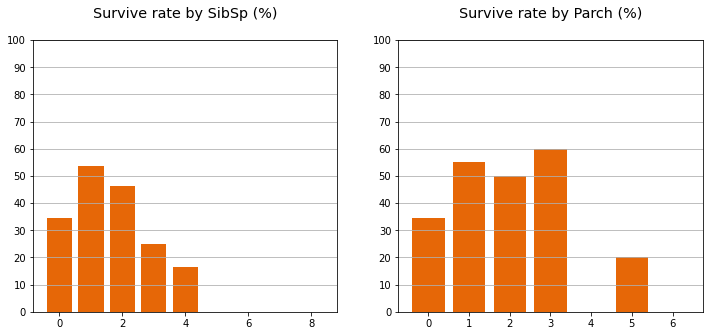

In [11]:
# SibSAp and parch feature Analisys

plt.figure(figsize=(12, 5))
k=121
for ftr in ['SibSp','Parch']:
    plt.subplot(k)
    k+=1
    tmp = train_df[[ftr, 'Survived']].groupby([ftr], as_index=False).mean()
    plt.bar(tmp[ftr],tmp['Survived']*100, color=BAR_COLOR)
    plt.title("Survive rate by " + ftr + " (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
    plt.yticks(ticks=range(0,101,10))
    plt.grid(axis='y')

print(train_df['SibSp'].value_counts())
print("\n")
print(train_df['Parch'].value_counts())

As we can see passengers who were alone on the ship had lower survival rate. That's because people with family had a bigger drive for survival so they could be alive to save their family.

That's why is best to transform those two features into one feature Is_Alone which is 1 is (SibSp + Parch == 0) or 0 if (SibSp + Parch > 0).

In [12]:
for dataset in train_and_test:
    dataset['Is_Alone_tmp'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[(dataset['Is_Alone_tmp'] == 0), 'Is_Alone'] = 1
    dataset.loc[(dataset['Is_Alone_tmp'] >  0), 'Is_Alone'] = 0
    dataset['Is_Alone'] = dataset['Is_Alone'].astype(int)

train_df = train_df.drop(['SibSp', 'Parch', 'Is_Alone_tmp'], axis=1)
test_df  =  test_df.drop(['SibSp', 'Parch', 'Is_Alone_tmp'], axis=1)
train_and_test = [train_df,test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Is_Alone
0,0,3,1,2,0,0,0
1,1,1,0,3,7,1,0
2,1,3,0,2,2,0,1
3,1,1,0,3,6,0,0
4,0,3,1,3,2,0,1


Now we have data shaped in numerical values and ready to be used for predictive modeling. Next step is to create input and output for models.
Everything except survived is input and output is only survived.
Since we have no results for test data (test is used for kaggle submission) data from test_df is not important here.

In [13]:
# x_train, y_train, x_test creating from existing dataframe

splited_df = model_selection.train_df(n_splits = 10, test_size = 0.2, train_size = 0.8, random_state = 0 )

x_train = splited_df.drop("Survived", axis=1)
y_train = splited_df["Survived"]
x_test  = test_df.copy()

In [14]:
# Logistic regression used for correlation coefficients

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
print("Accuracy score is: " + str(acc_log) + "\n")

coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

Accuracy score is: 79.12



,Feature,Correlation
4,Embarked,0.297638
5,Is_Alone,-0.006051
3,Fare,-0.007361
2,Age,-0.316280
0,Pclass,-1.192251
1,Sex,-2.481412


As we can see Pclass and Sex have highest correlation. Fare and Is_Alone have surprisingly low correlation (<0.01).

In [ ]:
# Decicion tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)

# Random forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)

# K- nearest neighbour

knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train, y_train)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)

# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
acc_gauss = round(gaussian.score(x_train, y_train) * 100, 2)

# Support Vector Machines

svc = SVC()
svc.fit(x_train, y_train)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)

# Models accuracy table

models_acc = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Logistic Reg.', 
              'Random Forest', 'Naive Bayes',
              'Decision Tree'],
    'Accuracy':  [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gauss,
                  acc_decision_tree]})
models_acc.sort_values(by='Accuracy', ascending=False)

In [22]:
ML_Algs = [
          LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          KNeighborsClassifier(n_neighbors = 4),
          GaussianNB(),
          SVC(),
          XGBClassifier()
]

ML_Algs_table_columns = [
                         'Algorithm',
                         'Train_Accuracy',
                         'Test_Accuracy',
                         'Time'
]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

ML_Algs_table = pd.DataFrame(columns = ML_Algs_table_columns)
k=0
for alg in ML_Algs:
    alg.fit(x_train, y_train)
    ML_Algs_table.loc[k,'Algorithm'] = alg.__class__.__name__
    ML_Algs_table.loc[k,'Train_Accuracy'] = round(alg.score(x_train, y_train) * 100, 2) 
    k+=1

ML_Algs_table.sort_values(by = ['Train_Accuracy'], ascending=False)

,Algorithm,Train_Accuracy,Test_Accuracy,Time
1,DecisionTreeClassifier,87.54,NaN,NaN
2,RandomForestClassifier,87.54,NaN,NaN
3,KNeighborsClassifier,85.41,NaN,NaN
6,XGBClassifier,84.4,NaN,NaN
5,SVC,80.36,NaN,NaN
0,LogisticRegression,79.12,NaN,NaN
4,GaussianNB,76.88,NaN,NaN


In [ ]:
# test cell

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Is_Alone
0,0,3,1,2,0,0,0
1,1,1,0,3,7,1,0
2,1,3,0,2,2,0,1
3,1,1,0,3,6,0,0
4,0,3,1,3,2,0,1
